# Ch. 5 - Multiclass Regression
In this chapter we will take a big step from a binary classification which can only differentiate between two classes to multiclass classification which can differentiate between any number of classes. As a brief motivation check out this clip from the HBO show 'Silicon Valley':

[![IMAGE ALT TEXT HERE](https://img.youtube.com/vi/ACmydtFDTGs/0.jpg)](https://www.youtube.com/watch?v=ACmydtFDTGs)

The app in the show can only differentiate between Hot Dog and Not Hot Dog, a classic binary classification task. [The HBO team actually made a Hot Dog / Not Hot Dog app](https://medium.com/@timanglade/how-hbos-silicon-valley-built-not-hotdog-with-mobile-tensorflow-keras-react-native-ef03260747f3) but of course it is not very useful if our classifier can only separate two things. We need a way of doing multiclass regression. 

This weeks challenge will also involve multiclass regression with the [Zalando Fashion MNIST dataset](https://github.com/zalandoresearch/fashion-mnist). In this chapter we will give a closer look at the underlying technology with a simpler problem.

In [1]:
# Package imports
# Matplotlib is a matlab like plotting library
import matplotlib
import matplotlib.pyplot as plt
# Numpy handles matrix operations
import numpy as np
# SciKitLearn is a useful machine learning utilities library
import sklearn
# The sklearn dataset module helps generating datasets
import sklearn.datasets
import sklearn.linear_model
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score
# Display plots inline and change default figure size
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (10.0, 8.0)

In [2]:
# Helper function to plot a decision boundary.
# If you don't fully understand this function don't worry, it just generates decision boundary plot
def plot_decision_boundary(pred_func):
    # Set min and max values and give it some padding
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole gid
    Z = pred_func(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Accent)

## The problem
We have three distinct groups of customers, men women and children. Our fantastic feature engineering team has already come up with two metrics to separate them. What is needed is an automatic way to distinguish whether a customer is a man, a woman or a child. Our task today is to build a neural network that can handle this separation.

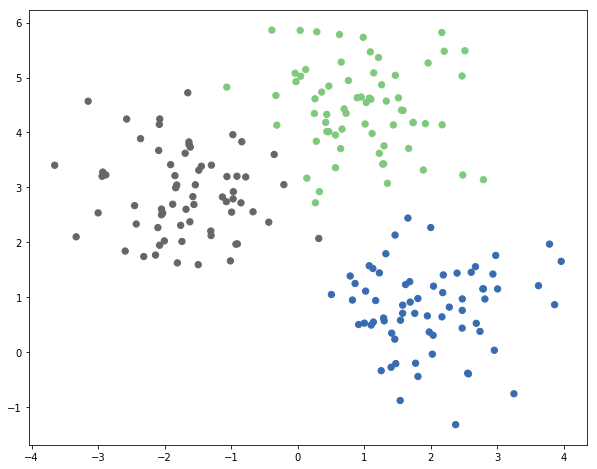

In [3]:
# Generate a dataset and plot it
np.random.seed(0)
X, y = sklearn.datasets.make_blobs(n_samples=200,centers=3,cluster_std=0.8)
plt.scatter(X[:,0], X[:,1], s=40, c=y, cmap=plt.cm.Accent)

## One hot encoding
Let's have a look at the data.

In [4]:
# Print data for the first ten customers
print('X')
print(X[:10])
# Print the classes for the first ten customers
print('y:')
print(y[:10])

X
[[-1.69242695  3.62202539]
 [ 0.69794036  4.4288665 ]
 [ 1.10022802  4.60631734]
 [-1.44872404  3.38424521]
 [ 1.21486062  5.36489604]
 [-0.90830163  1.97077775]
 [ 2.47211942  0.43703328]
 [ 1.65684156  2.4412893 ]
 [ 1.07779975  4.62537882]
 [-1.67942681  2.60200265]]
y:
[2 0 0 2 0 2 1 1 0 2]


The input matrix X is already well formatted and ready for our neural network but there is a problem with y. The classes are codified from 0 to 2, but we they are categorical. We need a categorical representation like this:

$$0 \rightarrow man \rightarrow \begin{pmatrix}1 & 0 & 0\end{pmatrix}$$

$$1 \rightarrow woman \rightarrow \begin{pmatrix}0 & 1 & 0\end{pmatrix}$$

$$2 \rightarrow child \rightarrow \begin{pmatrix}0 & 0 & 1\end{pmatrix}$$

This encoding is called one hot encoding since one element of the resulting vector is 'hot', representing the category. Luckily, SciKitLearn has a handy function for this purpose:

In [5]:
# Reshape from array to vector
y = y.reshape(200,1)
# Generate one hot encoding
enc = OneHotEncoder()
onehot = enc.fit_transform(y)
# Convert to numpy vector
y = onehot.toarray()

Our neural network will therefore also have an output dimensionality of 3:

![Multiclass NN](./assets/multiclass.jpg)

## Softmax
Hawk eyes will have spotted that our new network also uses a new activation function for the final layer: The [softmax activation](https://en.wikipedia.org/wiki/Softmax_function). The softmax function is a generalized version of the sigmoid function. It works with any output vector size, enabling it to handle any amount of classes $K$. It's output can be interpreted as the probability distribution over the different classes for a given example. For example if the output of softmax for a given example is $\begin{pmatrix}0.6 & 0.3 & 0.1\end{pmatrix}$ we can interpret it as an 80% probability that the customer is a man, a 30% probability that it is a woman and a 10% probability that it is a child. The softmax function gets computed as:
$$softmax(z) = \frac{e^{z}}{\sum_{k=1}^K e^{z_k}} \text{for } j = 1,...,K$$
Or in python code:

In [6]:
def softmax(z):
    '''
    Calculates the softmax activation of a given input x
    See: https://en.wikipedia.org/wiki/Softmax_function
    '''
    #Calculate exponent term first
    exp_scores = np.exp(z)
    return exp_scores / np.sum(exp_scores, axis=1, keepdims=True)

## Generalized loss function
Since we generalized the activation function we also have to generalize the loss function. The generalized loss function working with any vector with $K$ categories is as follows:
$$
\begin{aligned}
L(y,\hat{y}) = - \frac{1}{m} \sum \sum y \log\hat{y}
\end{aligned}
$$

You can show that this is the same as the log loss function from earlier where $K = 1$
In python code it looks like this:

In [7]:
def softmax_loss(y,y_hat):
    '''
    Calculates the generalized logistic loss between a prediction y_hat and the labels y
    See: http://ufldl.stanford.edu/tutorial/supervised/SoftmaxRegression/

    We need to clip values that get too close to zero to avoid zeroing out. 
    Zeroing out is when a number gets so small that the computer replaces it with 0.
    Therefore, we clip numbers to a minimum value.
    '''
    # Clipping calue
    minval = 0.000000000001
    # Number of samples
    m = y.shape[0]
    # Loss formula, note that np.sum sums up the entire matrix and therefore does the job of two sums from the formula
    loss = -1/m * np.sum(y * np.log(y_hat.clip(min=minval)))
    return loss

## Generalized loss derivative
Since element wise subtraction makes no difference about the dimensionality of the matrices subtracted the derivative of the generalized loss function is the same:
$$\frac{dL(y,\hat{y})}{d\hat{y}} = (\hat{y} - y)$$

Or in python code

In [8]:
# Log loss derivative, equal to softmax loss derivative
def loss_derivative(y,y_hat):
    '''
    Calculates the gradient (derivative) of the loss between point y and y_hat
    See: https://stats.stackexchange.com/questions/219241/gradient-for-logistic-loss-function
    '''
    return (y_hat-y)

## Building the rest of the network
After we changed the activation function and the loss function and its derivative, the rest of the network does not change very much. We just need to replace the functions in our forward and backward propagation code

In [9]:
def tanh_derivative(x):
    '''
    Calculates the derivative of the tanh function that is used as the first activation function
    See: https://socratic.org/questions/what-is-the-derivative-of-tanh-x
    '''
    return (1 - np.power(x, 2))

In forward propagation the softmax function replaces the sigmoid function

In [10]:
def forward_prop(model,a0):
    '''
    Forward propagates through the model, stores results in cache.
    See: https://stats.stackexchange.com/questions/147954/neural-network-forward-propagation
    A0 is the activation at layer zero, it is the same as X
    '''
    
    # Load parameters from model
    W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']
    
    # Linear step
    z1 = a0.dot(W1) + b1
    
    # First activation function
    a1 = np.tanh(z1)
    
    # Second linear step
    z2 = a1.dot(W2) + b2
    
    # Second activation function
    a2 = softmax(z2)
    cache = {'a0':a0,'z1':z1,'a1':a1,'z1':z1,'a2':a2}
    return cache

Since the derivative of the loss function did not change, nothing changes in the backward propagation

In [11]:
def backward_prop(model,cache,y):
    '''
    Backward propagates through the model to calculate gradients.
    Stores gradients in grads dictionary.
    See: https://en.wikipedia.org/wiki/Backpropagation
    '''
    # Load parameters from model
    W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']
    
    # Load forward propagation results
    a0,a1, a2 = cache['a0'],cache['a1'],cache['a2']
    
    # Get number of samples
    m = y.shape[0]
    
    # Backpropagation
    # Calculate loss derivative with respect to output
    dz2 = loss_derivative(y=y,y_hat=a2)
   
    # Calculate loss derivative with respect to second layer weights
    dW2 = 1/m*(a1.T).dot(dz2)
    
    # Calculate loss derivative with respect to second layer bias
    db2 = 1/m*np.sum(dz2, axis=0)
    
    # Calculate loss derivative with respect to first layer
    dz1 = np.multiply(dz2.dot(W2.T) ,tanh_derivative(a1))
    
    # Calculate loss derivative with respect to first layer weights
    dW1 = 1/m*np.dot(a0.T, dz1)
    
    # Calculate loss derivative with respect to first layer bias
    db1 = 1/m*np.sum(dz1, axis=0)
    
    # Store gradients
    grads = {'dW2':dW2,'db2':db2,'dW1':dW1,'db1':db1}
    return grads

Initializing and updating parameters was also done the exact same way

In [12]:
def initialize_parameters(nn_input_dim,nn_hdim,nn_output_dim):
    '''
    Initializes weights with random number between -1 and 1
    Initializes bias with 0
    Assigns weights and parameters to model
    '''
    # First layer weights
    W1 = 2 *np.random.randn(nn_input_dim, nn_hdim) - 1
    
    # First layer bias
    b1 = np.zeros((1, nn_hdim))
    
    # Second layer weights
    W2 = 2 * np.random.randn(nn_hdim, nn_output_dim) - 1
    
    # Second layer bias
    b2 = np.zeros((1, nn_output_dim))
    
    # Package and return model
    model = { 'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2}
    return model

In [13]:
def update_parameters(model,grads,learning_rate):
    '''
    Updates parameters accoarding to gradient descent algorithm
    See: https://en.wikipedia.org/wiki/Gradient_descent
    '''
    # Load parameters
    W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']
    
    # Update parameters
    W1 -= learning_rate * grads['dW1']
    b1 -= learning_rate * grads['db1']
    W2 -= learning_rate * grads['dW2']
    b2 -= learning_rate * grads['db2']
    
    # Store and return parameters
    model = { 'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2}
    return model

## Making predictions
To make predictions, we do not need the probability of all categories but the most likely category. We can do this with the ```argmax()``` command from numpy, which gives us the category with the highes likely-hood back. This also turns our onehot vector back into a categorical representation with the value 0 to 2. So when we calculate the accuracy, we also need to convert y back to its original representation.

In [14]:
def predict(model, x):
    '''
    Predicts y_hat as 1 or 0 for a given input X
    '''
    # Do forward pass
    c = forward_prop(model,x)
    #get y_hat
    y_hat = np.argmax(c['a2'], axis=1)
    return y_hat

The training process does not change.

In [15]:
def train(model,X_,y_,learning_rate, epochs=20000, print_loss=False):
    # Gradient descent. Loop over epochs
    for i in range(0, epochs):

        # Forward propagation
        cache = forward_prop(model,X_)
        #a1, probs = cache['a1'],cache['a2']
        # Backpropagation
        
        grads = backward_prop(model,cache,y_)
        # Gradient descent parameter update
        # Assign new parameters to the model
        model = update_parameters(model=model,grads=grads,learning_rate=learning_rate)
    
        # Pring loss & accuracy every 100 iterations
        if print_loss and i % 100 == 0:
            a2 = cache['a2']
            print('Loss after iteration',i,':',softmax_loss(y_,a2))
            y_hat = predict(model,X_)
            y_true = y_.argmax(axis=1)
            print('Accuracy after iteration',i,':',accuracy_score(y_pred=y_hat,y_true=y_true)*100,'%')
    
    return model

We will train this model with a hidden layer size of 3 and a learning rate of 0.01, feel free to try different values.

In [16]:
# Hyper parameters
hiden_layer_size = 3
# I picked this value because it showed good results in my experiments
learning_rate = 0.01

In [17]:
# Initialize the parameters to random values. We need to learn these.
np.random.seed(0)
# This is what we return at the end
model = initialize_parameters(nn_input_dim=2, nn_hdim= hiden_layer_size, nn_output_dim= 3)
model = train(model,X,y,learning_rate=learning_rate,epochs=1000,print_loss=True)

Loss after iteration 0 : 1.51792957307
Accuracy after iteration 0 : 33.0 %
Loss after iteration 100 : 1.24348172741
Accuracy after iteration 100 : 33.0 %
Loss after iteration 200 : 1.12207560444
Accuracy after iteration 200 : 33.0 %
Loss after iteration 300 : 1.04454416492
Accuracy after iteration 300 : 33.5 %
Loss after iteration 400 : 0.970112771529
Accuracy after iteration 400 : 45.5 %
Loss after iteration 500 : 0.886588543009
Accuracy after iteration 500 : 51.0 %
Loss after iteration 600 : 0.803687764989
Accuracy after iteration 600 : 58.0 %
Loss after iteration 700 : 0.740613990441
Accuracy after iteration 700 : 60.5 %
Loss after iteration 800 : 0.697828881817
Accuracy after iteration 800 : 68.5 %
Loss after iteration 900 : 0.664528474694
Accuracy after iteration 900 : 69.0 %


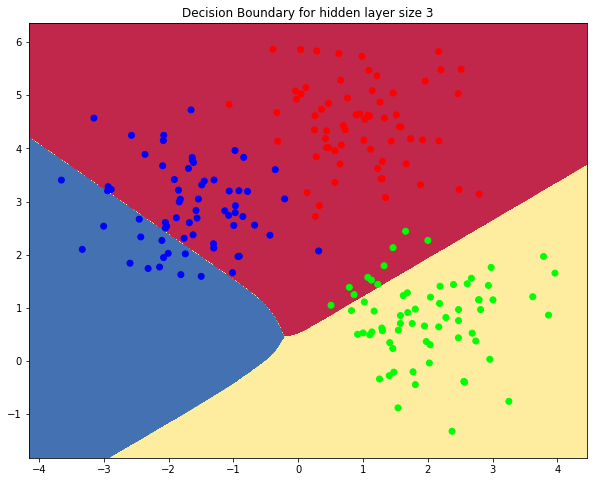

In [18]:
# Plot the decision boundary
plot_decision_boundary(lambda x: predict(model,x))
plt.title("Decision Boundary for hidden layer size 3")

## Summary
And voila! We now can classify with any amount of classes. This will be very important in this weeks challenge.